In [2]:
!pip3 install vowpalwabbit
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.2MB 9.1MB/s 


Original code from: https://vowpalwabbit.org/tutorials/cb_simulation.html

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [6]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [118]:
def plot_ctr(num_iterations, ctr, title = None):
    if title != None:
        plt.title(title)
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    plt.legend()

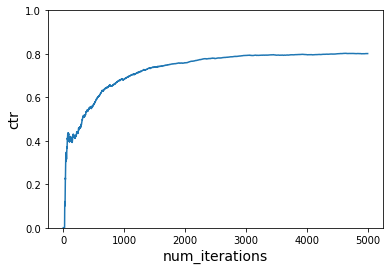

In [12]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

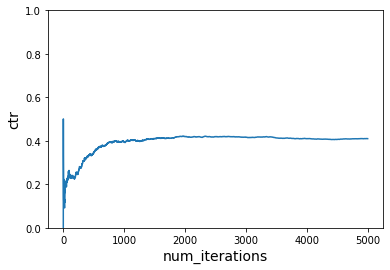

In [13]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

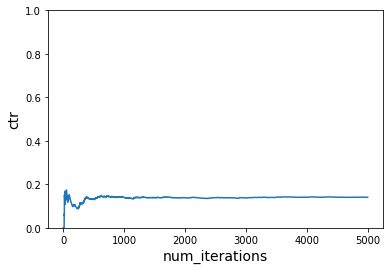

In [14]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [16]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [55]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

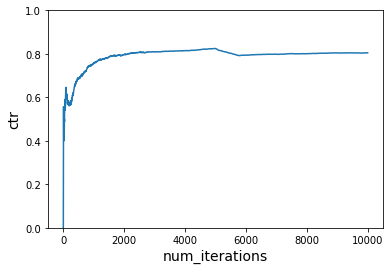

In [59]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

**Adding Noise + Multiple Changes to Reward Distribution**

Assumption: 'introducing varying noise' is assumed to mean adding a random noise distribution with a mean of 0, instead of a noise distribution that is time variant.

This code contains a modified version of the get_cost function that generates random noise which is added to the reward signal. This modified function has a new input: the noise to signal ratio.

There will also be 3 changes to the reward distribution over the course of training.

In [83]:
#Defining the various noisy cost functions
#New input: noise_ratio

def get_noisy_cost1(context,action,noise_ratio):
    #this modified function is identical in structure to the previous get_cost functions, but with an additional noise generator.

    #random.random() outputs values from 0 to 1, so the following code centres the distribution around 0 and scales it
    #the reward values range from -1 to 0, so to scale the noise, we only need to multiply it by the noise_ratio    
    noise_val = noise_ratio*(random.random() -  1/2)

    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val

def get_noisy_cost2(context,action,noise_ratio):
    noise_val = noise_ratio * (random.random() -  1/2)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val

def get_noisy_cost3(context,action,noise_ratio):
    noise_val = noise_ratio * (random.random() -  1/2)
    if context['user'] == "Tom":        
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE + noise_val
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_val
        else:
            return USER_DISLIKED_ARTICLE + noise_val

In [80]:
#Defining a function to run a simulation with multiple noisy cost functions
#New input: noise_ratio

def run_simulation_multiple_noisy_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, noise_ratio, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action, noise_ratio)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [129]:
#Defining a modified ctr plotting function which takes in an array of ctr series and labels
#modified inputs: ctr is replaced by ctr_array, which is a 2D array with the following structure: [[ctr_1,"ctr_1_label"],[ctr_2,"ctr_2_label"]...]
#This new function can now plot multiple labelled ctr series

def plot_ctr_multiple(num_iterations, ctr_array, title= None):
    if title != None:
        plt.title(title)
    for ctr in ctr_array:
      plt.plot(range(1,num_iterations+1), ctr[0],label=ctr[1])
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.legend(loc="lower right")
    plt.ylim([0,1])
    plt.legend()

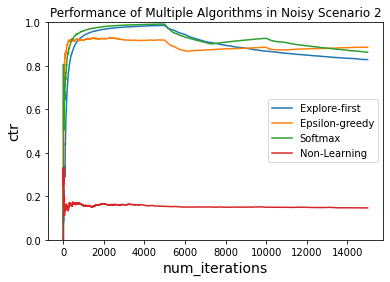

In [139]:
#initializing the different algorithms
vw_explore_first = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")
vw_epsilon_greedy = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")
vw_softmax = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations_per_cost_func = 5000
noise_ratio = 0.05

cost_functions = [get_noisy_cost1, get_noisy_cost2, get_noisy_cost3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

#ctr series for each algorithm
ctr_explore_first = run_simulation_multiple_noisy_cost_functions(vw_explore_first, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, noise_ratio)
ctr_non_learning = run_simulation_multiple_noisy_cost_functions(vw_epsilon_greedy, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, noise_ratio, do_learn=False)
ctr_epsilon_greedy = run_simulation_multiple_noisy_cost_functions(vw_epsilon_greedy, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, noise_ratio)
ctr_softmax = run_simulation_multiple_noisy_cost_functions(vw_softmax, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, noise_ratio)

#Initializes a 2D array in which each element contains a ctr series as well as the label for that series
ctr_array = [[ctr_explore_first,"Explore-first"],[ctr_epsilon_greedy,"Epsilon-greedy"],[ctr_softmax,"Softmax"],[ctr_non_learning,"Non-Learning"]]

#The plot_ctr function has been edited to support a plot title and can plot multiple series at a time
plot_ctr_multiple(total_iterations, ctr_array,"Performance of Multiple Algorithms in Noisy Scenario 2")

**Comments on Algorithm Performance:**

The Explore-first algorithm intitially performs very well, with an initial mean click through rate >0.95. This is likely because the initial randomness allows for thorough exploration of the state space. However, performance declines consistently once the reward distribution is changed. This is to be expected, as the policy learned from the initial exploration is no longer optimal. 

The Epsilon-Greedy algorithm consistently performs well, with a mean click through rate around ~0.9. After the reward distribution is changed, this algorithm suffers an initial drop in performance but soon improves. This is expected, because the epsilon-greedy exploration allows for changes in the reward distribution to be discovered relatively quickly.

The Softmax algorithm also performs very well initially. It reaches a mean click through rate >0.95 until the first change in the reward distribution, after which performance deteriorates. Performance continues to decline for some time after the change, before improving. This is to be expected, because the non-zero tau value leads to less random exploration. This means that changes in the reward distribution aren't discovered as quickly.

The Non-Learning algorithm consistently performs poorly, with a mean click through rate around ~0.15, which is significantly worse than all other algorithms. This value does not change as the reward distribution changes.
